In [1]:
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
##########  Using gym
import gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
tf.__version__

'2.16.1'

In [5]:
#!pip install gym[accept-rom-license]

In [6]:
# MsPacman-ram-v5 environment
env = gym.make("ALE/MsPacman-ram-v5", render_mode='rgb_array')

In [7]:
#The inputs are 128-dimensional:
env.observation_space

Box(0, 255, (128,), uint8)

In [8]:
obs = env.reset()
obs

(array([  0, 112, 114, 115,   0,   3,  88,  88,  88,  88,  88,   0,  80,
         80,  80,  50,  98,   0,   0,   3,   0,   0,   1,   0,   0,   1,
          6,   6, 198,   4,  71,   0,  45,   1,   0, 198, 198,   0,   0,
          0,   0,  16,  52,   0,   0, 120,   0, 100, 130,   0,   0, 134,
          1, 222,   0,   1,   3,   0,   6,  80, 255, 255,   0, 255, 255,
         80, 255, 255,  80, 255, 255,  80, 255, 255,  80, 191, 191,  80,
        191, 191,  80, 191, 191,  80, 255, 255,  80, 255, 255,  80, 255,
        255,  80, 255, 255,   0, 255, 255,  80, 255, 255,  20, 223,  43,
        217, 123, 217, 123, 217, 123, 217, 123, 217, 123, 217, 221,   0,
         63,   0,   0,   0,   0,   0,   2,  66, 240, 146, 215], dtype=uint8),
 {'lives': 3, 'episode_frame_number': 0, 'frame_number': 0})

In [9]:
env.action_space

Discrete(9)

In [10]:
# Let's create a simple policy network with 9 output neurons (one per possible action):
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(128, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

In [11]:
def pacman_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, tr,info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def pacman_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        obs=obs[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = pacman_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [12]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [13]:
n_iterations = 110
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

In [14]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [15]:
#env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = pacman_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

c:\Users\marta\anaconda3\envs\ML2\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iteration: 1/110, mean reward: 210.0  

KeyboardInterrupt: 

In [ ]:
mean_rewards_str = [str(r) for r in mean_rewards]

In [ ]:
with open("mean_rewards_reinforcement.txt", "w") as file:
    file.write(",".join(mean_rewards_str))

In [ ]:
# Leer la lista desde el archivo de texto
with open("mean_rewards_reinforcement.txt", "r") as file:
    loaded_list_mean_reward = [float(e) for e in file.readline().split(",")]

In [ ]:
loaded_list_mean_reward == mean_rewards

True

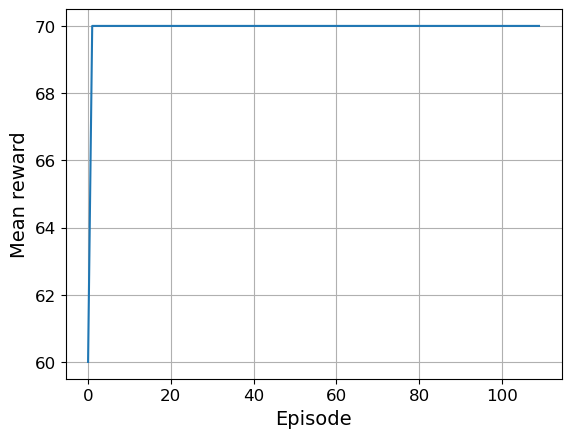

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [ ]:
def pacman_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    rewards = []
    env = gym.make("ALE/MsPacman-ram-v5")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        rewards.append(reward)
        if done:
            break
    env.close()
    return frames,rewards

In [24]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [25]:
frames, rewards = pacman_render_policy_net(model)

0


ValueError: in user code:

    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Alvaro\miniconda3\envs\rf_tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128), found shape=(32, 1, 4)


In [ ]:
plot_animation(frames)